In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torchvision.transforms as transforms
import torchvision.models as models
from torch import optim
import json
import torch.optim.lr_scheduler as lr_scheduler
import os

from tqdm import tqdm
from utils import util_functions, metric_functions, custom_dataset

In [2]:
train_labels_path = os.path.join('dataset', 'train.csv')
test_labels_path = os.path.join('dataset', 'test.csv')

train_images_dir = os.path.join('dataset', 'train')
test_images_dir = os.path.join('dataset', 'test')

train_labels_df = pd.read_csv(train_labels_path)
test_labels_df = pd.read_csv(test_labels_path)

In [3]:
img_size = 400
# Calculate the mean and std of dataset
base_transformer =  transforms.Compose([transforms.Resize((img_size, img_size)),
                                transforms.ToTensor()])
base_dataset = custom_dataset.CustomDataset(images_dir=train_images_dir, 
                                                df=train_labels_df, transforms=base_transformer)

mean, std = util_functions.calculate_mean_std_of_dataset(base_dataset)
print(mean)
print(std)

tensor([0.4741, 0.4623, 0.4588])
tensor([0.2617, 0.2613, 0.2666])


In [4]:
# Calculate the mean and std of dataset

base_dataset = custom_dataset.CustomDataset(images_dir=train_images_dir, 
                                                df=train_labels_df, transforms=base_transformer, is_test=False)

mean, std = util_functions.calculate_mean_std_of_dataset(base_dataset)



train_transformer = transforms.Compose([transforms.Resize((img_size, img_size)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(360),
                                # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
                                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

random_transoform = transforms.Compose([
    transforms.ColorJitter(brightness=0.3),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply([transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2))], p=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=23)], p=0.2),
    transforms.RandomAdjustSharpness(sharpness_factor = 10, p = 0.2),
    transforms.RandomApply([transforms.RandomResizedCrop(size=(img_size, img_size), scale=(0.5, 0.9))], p=0.5),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

base_test_dataset = custom_dataset.CustomDataset(images_dir=test_images_dir, 
                                                df=train_labels_df, transforms=base_transformer, is_test=True)

test_mean, test_std = util_functions.calculate_mean_std_of_dataset(base_test_dataset, is_test=True)
test_transformer = transforms.Compose([transforms.Resize((img_size, img_size)),
                                transforms.ToTensor(),
                                transforms.Normalize(test_mean, test_std)])

print(test_mean)
print(test_std)

tensor([0.4710, 0.4586, 0.4542])
tensor([0.2612, 0.2603, 0.2652])


In [5]:
import copy

train_size = int(0.8 * len(base_dataset))
val_size = len(base_dataset) - train_size
base_train_dataset, val_dataset = random_split(base_dataset, [train_size, val_size])
base_train_dataset = copy.deepcopy(base_train_dataset)
augment_dataset = copy.deepcopy(base_train_dataset)
augment_dataset2 = copy.deepcopy(base_train_dataset)
augment_dataset.dataset.transforms = train_transformer
augment_dataset2.dataset.transforms = random_transoform

val_dataset.dataset.transforms = test_transformer
train_dataset = ConcatDataset([base_train_dataset, augment_dataset, augment_dataset2])
test_dataset = custom_dataset.CustomDataset(images_dir=test_images_dir, 
                                                df=train_labels_df, transforms=test_transformer, is_test=True)

## Checking how many different classes we have
no_classes = len(list(train_labels_df['label'].unique()))

print(len(train_dataset), len(val_dataset), len(test_dataset))
BATCH_SIZE = 32 # efficientnetv2-m got cuda out of memory with 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

9924 827 4080


  0%|          | 0/16 [00:00<?, ?it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


SAVED-MODEL
Epoch: 1, Train Loss: 4.223313383734111, Train Accuracy: 13.008867392180573, Valid Loss: 2.8459095863195567, Valid Acc: 32.285368802902056


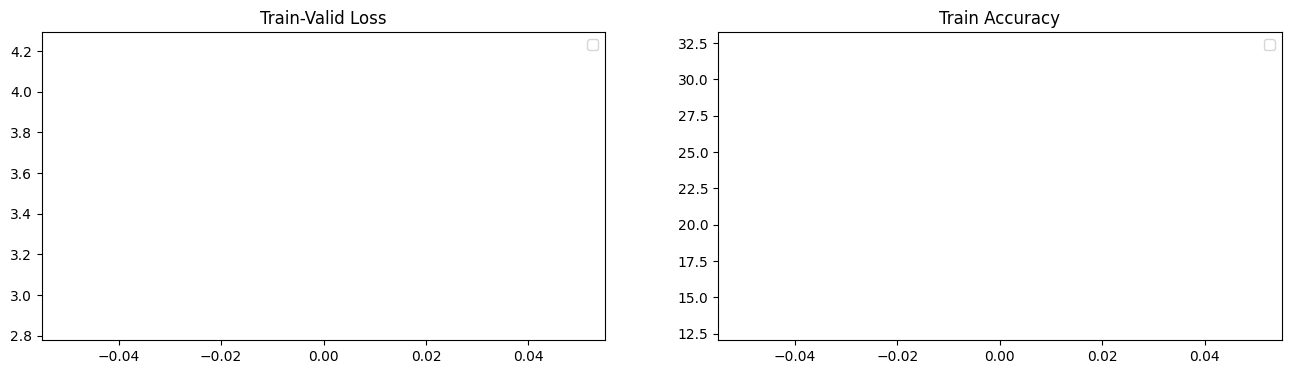

 12%|█▎        | 2/16 [04:15<29:56, 128.33s/it]

SAVED-MODEL
Epoch: 2, Train Loss: 2.2194923430777056, Train Accuracy: 51.33010882708585, Valid Loss: 1.768058336698092, Valid Acc: 57.557436517533255


 19%|█▉        | 3/16 [06:18<27:20, 126.17s/it]

SAVED-MODEL
Epoch: 3, Train Loss: 1.3536051912323073, Train Accuracy: 72.25916968964127, Valid Loss: 1.3708141767061675, Valid Acc: 67.23095525997581


 25%|██▌       | 4/16 [08:29<25:34, 127.88s/it]

SAVED-MODEL
Epoch: 4, Train Loss: 0.9259266626221574, Train Accuracy: 81.73115679161629, Valid Loss: 1.1846080216077657, Valid Acc: 70.61668681983072


 31%|███▏      | 5/16 [10:31<23:06, 126.03s/it]

SAVED-MODEL
Epoch: 5, Train Loss: 0.6843094581863888, Train Accuracy: 87.40427247077791, Valid Loss: 1.0435675497238452, Valid Acc: 73.63966142684401


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


SAVED-MODEL
Epoch: 6, Train Loss: 0.5189764782834283, Train Accuracy: 90.33655783958082, Valid Loss: 0.9726083943477044, Valid Acc: 73.51874244256348


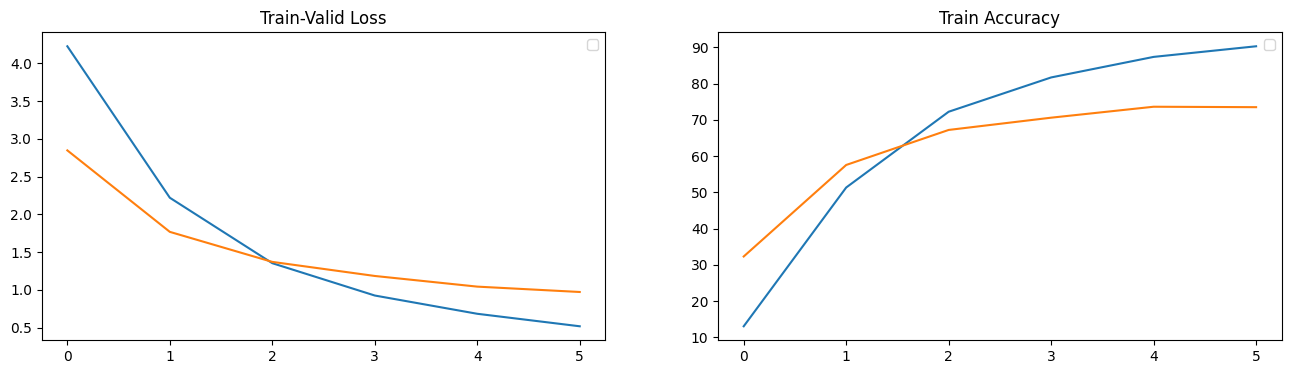

 44%|████▍     | 7/16 [14:44<18:59, 126.63s/it]

SAVED-MODEL
Epoch: 7, Train Loss: 0.4035357866927359, Train Accuracy: 92.86577992744861, Valid Loss: 0.9287276520178869, Valid Acc: 75.81620314389359


 50%|█████     | 8/16 [16:46<16:40, 125.04s/it]

SAVED-MODEL
Epoch: 8, Train Loss: 0.3154106937300929, Train Accuracy: 94.59895203546957, Valid Loss: 0.8443108682449048, Valid Acc: 77.50906892382103


 56%|█████▋    | 9/16 [18:58<14:51, 127.30s/it]

Epoch: 9, Train Loss: 0.2644648854156591, Train Accuracy: 95.67714631197099, Valid Loss: 0.8711186922513522, Valid Acc: 76.05804111245466


 62%|██████▎   | 10/16 [21:00<12:34, 125.67s/it]

SAVED-MODEL
Epoch: 10, Train Loss: 0.20790017354287135, Train Accuracy: 96.68480451430875, Valid Loss: 0.788366824388504, Valid Acc: 78.59733978234583


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch: 11, Train Loss: 0.17212261957898017, Train Accuracy: 97.3397823458283, Valid Loss: 0.7997117455189044, Valid Acc: 77.87182587666264


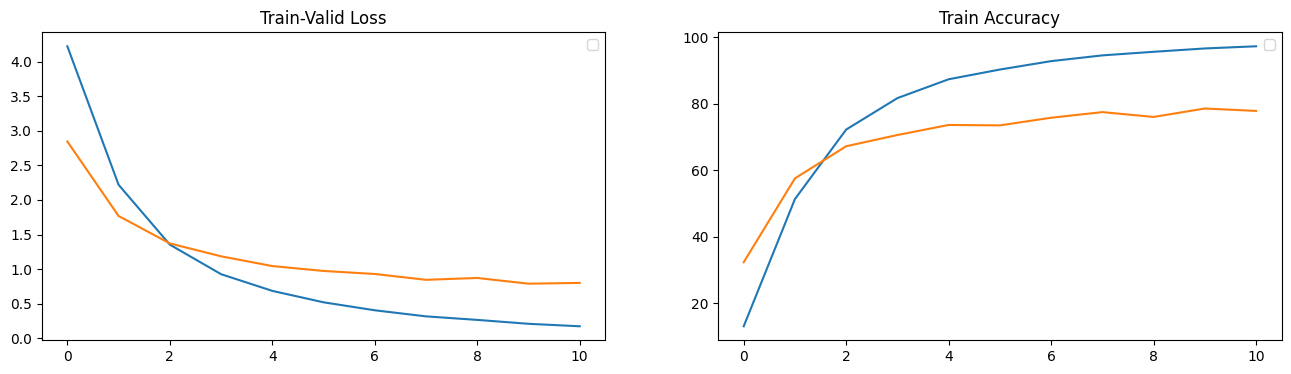

 75%|███████▌  | 12/16 [25:12<08:21, 125.45s/it]

SAVED-MODEL
Epoch: 12, Train Loss: 0.15131679472552426, Train Accuracy: 97.8335348649738, Valid Loss: 0.7765070452139928, Valid Acc: 78.47642079806529


 81%|████████▏ | 13/16 [27:15<06:13, 124.62s/it]

SAVED-MODEL
Epoch: 13, Train Loss: 0.13430950182738602, Train Accuracy: 97.91414752116083, Valid Loss: 0.7576378687069967, Valid Acc: 79.80652962515114


 88%|████████▊ | 14/16 [29:28<04:14, 127.15s/it]

SAVED-MODEL
Epoch: 14, Train Loss: 0.11025234447474744, Train Accuracy: 98.29705763804917, Valid Loss: 0.7435344159603119, Valid Acc: 81.01571946795647


 94%|█████████▍| 15/16 [31:29<02:05, 125.31s/it]

Epoch: 15, Train Loss: 0.09629816166349833, Train Accuracy: 98.4179766223297, Valid Loss: 0.7464268654584885, Valid Acc: 79.44377267230955


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch: 16, Train Loss: 0.07904889346085417, Train Accuracy: 98.93188230552197, Valid Loss: 0.7601260554332, Valid Acc: 79.32285368802901


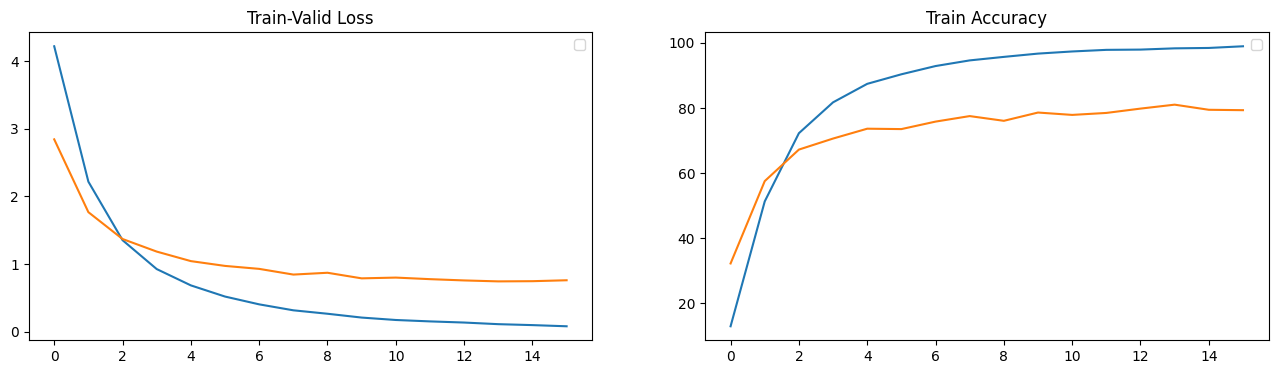

100%|██████████| 16/16 [33:36<00:00, 126.04s/it]


In [10]:
import torchvision
torch.cuda.empty_cache()
device = torch.device('cuda:1')
# load pretrained dataset
# model = models.resnet34(pretrained=True)
# model.classifier[1].out_features = no_classes
# model = models.resnet152(pretrained=True)

# model = models.mobilenet_v2(pretrained=True)
# model.classifier[-1].out_features = no_classes

# model = models.efficientnet_v2_s(pretrained=True)
# model.classifier[-1].out_features = no_classes

# model = models.resnet18(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, no_classes)

model = models.googlenet(pretrained=True)
model.fc.out_features = 100

# changing the last layer to our cause
# model = torchvision.models.efficientnet_v2_s(weights=torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
# model.fc = nn.Linear(model.fc.in_features, no_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
# learning_rate = 0.005
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay = 1e-5)
# lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
# optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
# scheduler = lr_scheduler.ReduceLROnPlateau()
n_epochs = 16

result_folder = metric_functions.train_loop(n_epochs, model, optimizer, train_loader, val_loader, device, criterion, scheduler=None)